In [111]:
import matplotlib.pyplot as plt

foldername = "results/sceptr/eval/trained-sceptr-caneval-6"
foldername = "trained-unidirectional-caneval-6"
rolling_window = 20
endofepoch = False

In [112]:
from utils.retrieve_stats import *

results = getstats(foldername, rolling_window=rolling_window, endofepoch=endofepoch)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams["figure.autolayout"] = True

stats, epochwisestats, aucstats, epochwiseauc = list(results.values())

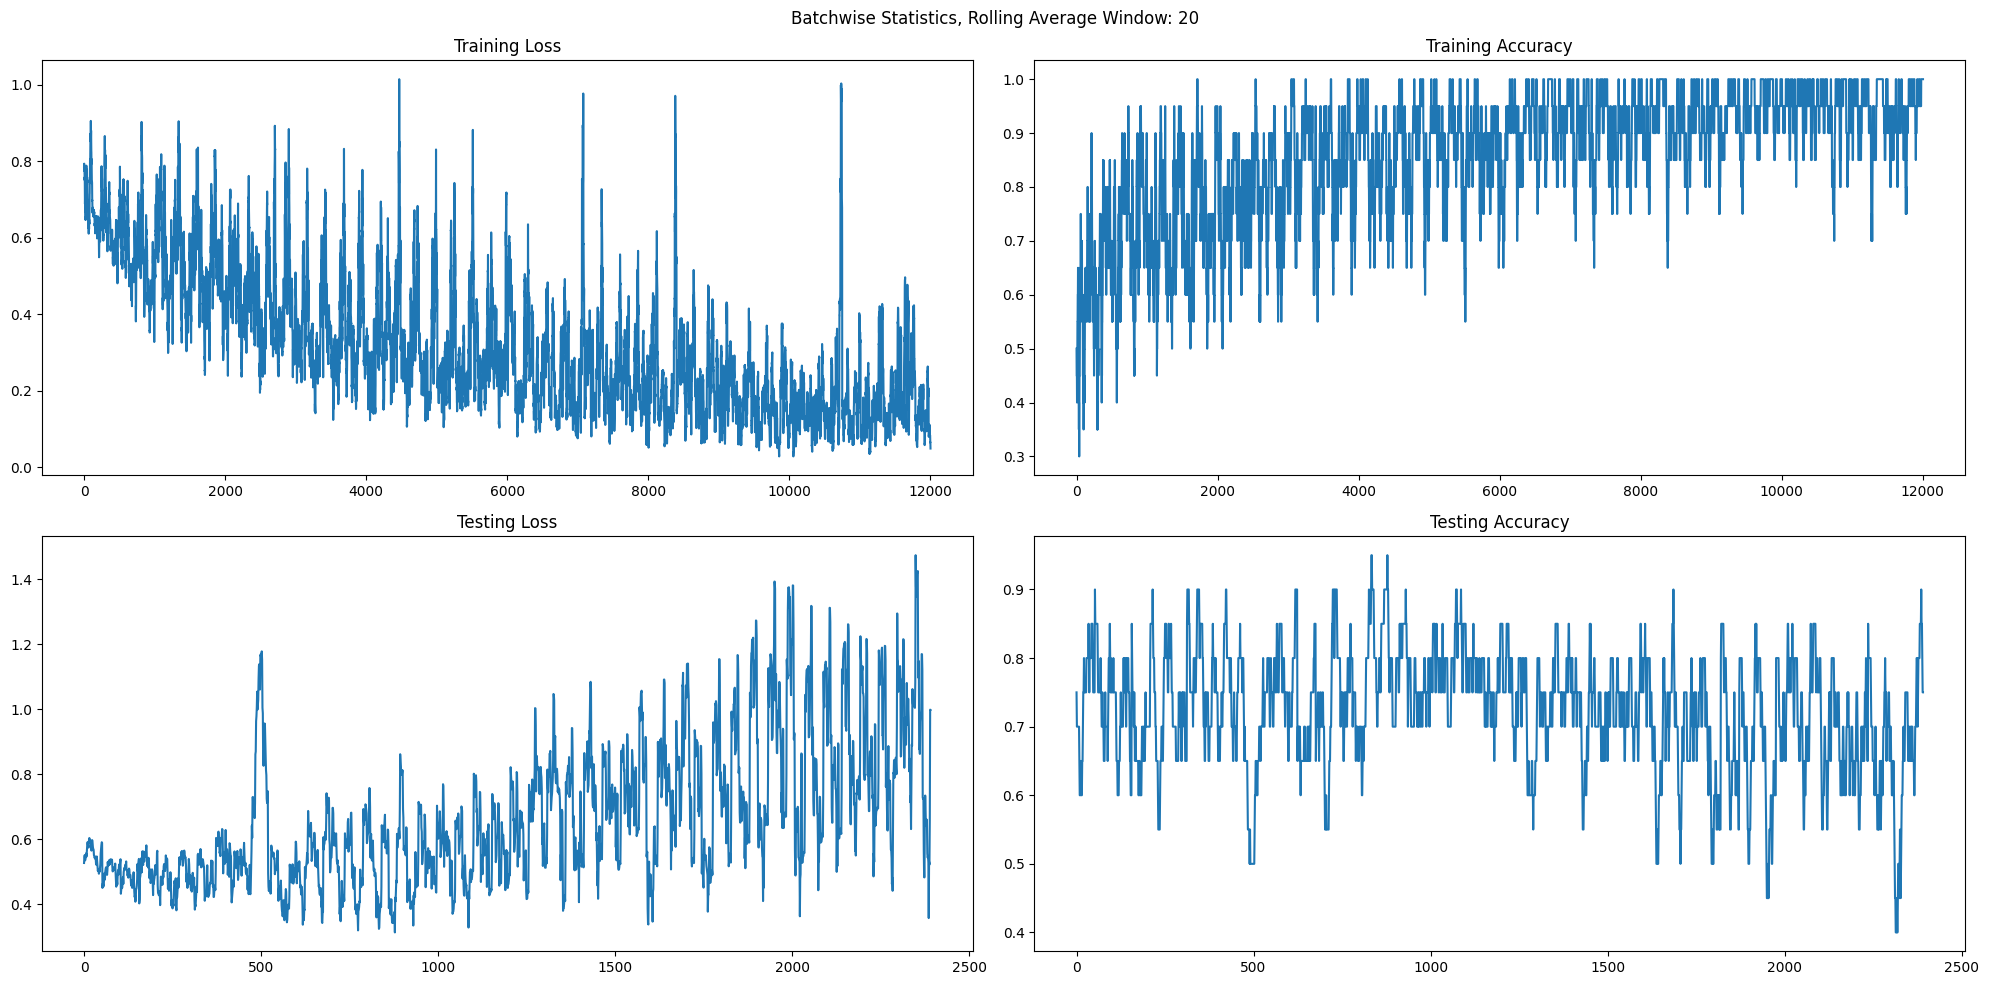

In [113]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(stats["train-loss.csv"])
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(stats["test-loss.csv"])
axs[1, 0].set_title("Testing Loss")

axs[0, 1].plot(stats["train-acc.csv"])
axs[0, 1].set_title("Training Accuracy")

axs[1, 1].plot(stats["test-acc.csv"])
axs[1, 1].set_title("Testing Accuracy")

fig.suptitle(f"Batchwise Statistics, Rolling Average Window: {rolling_window}")
plt.show()

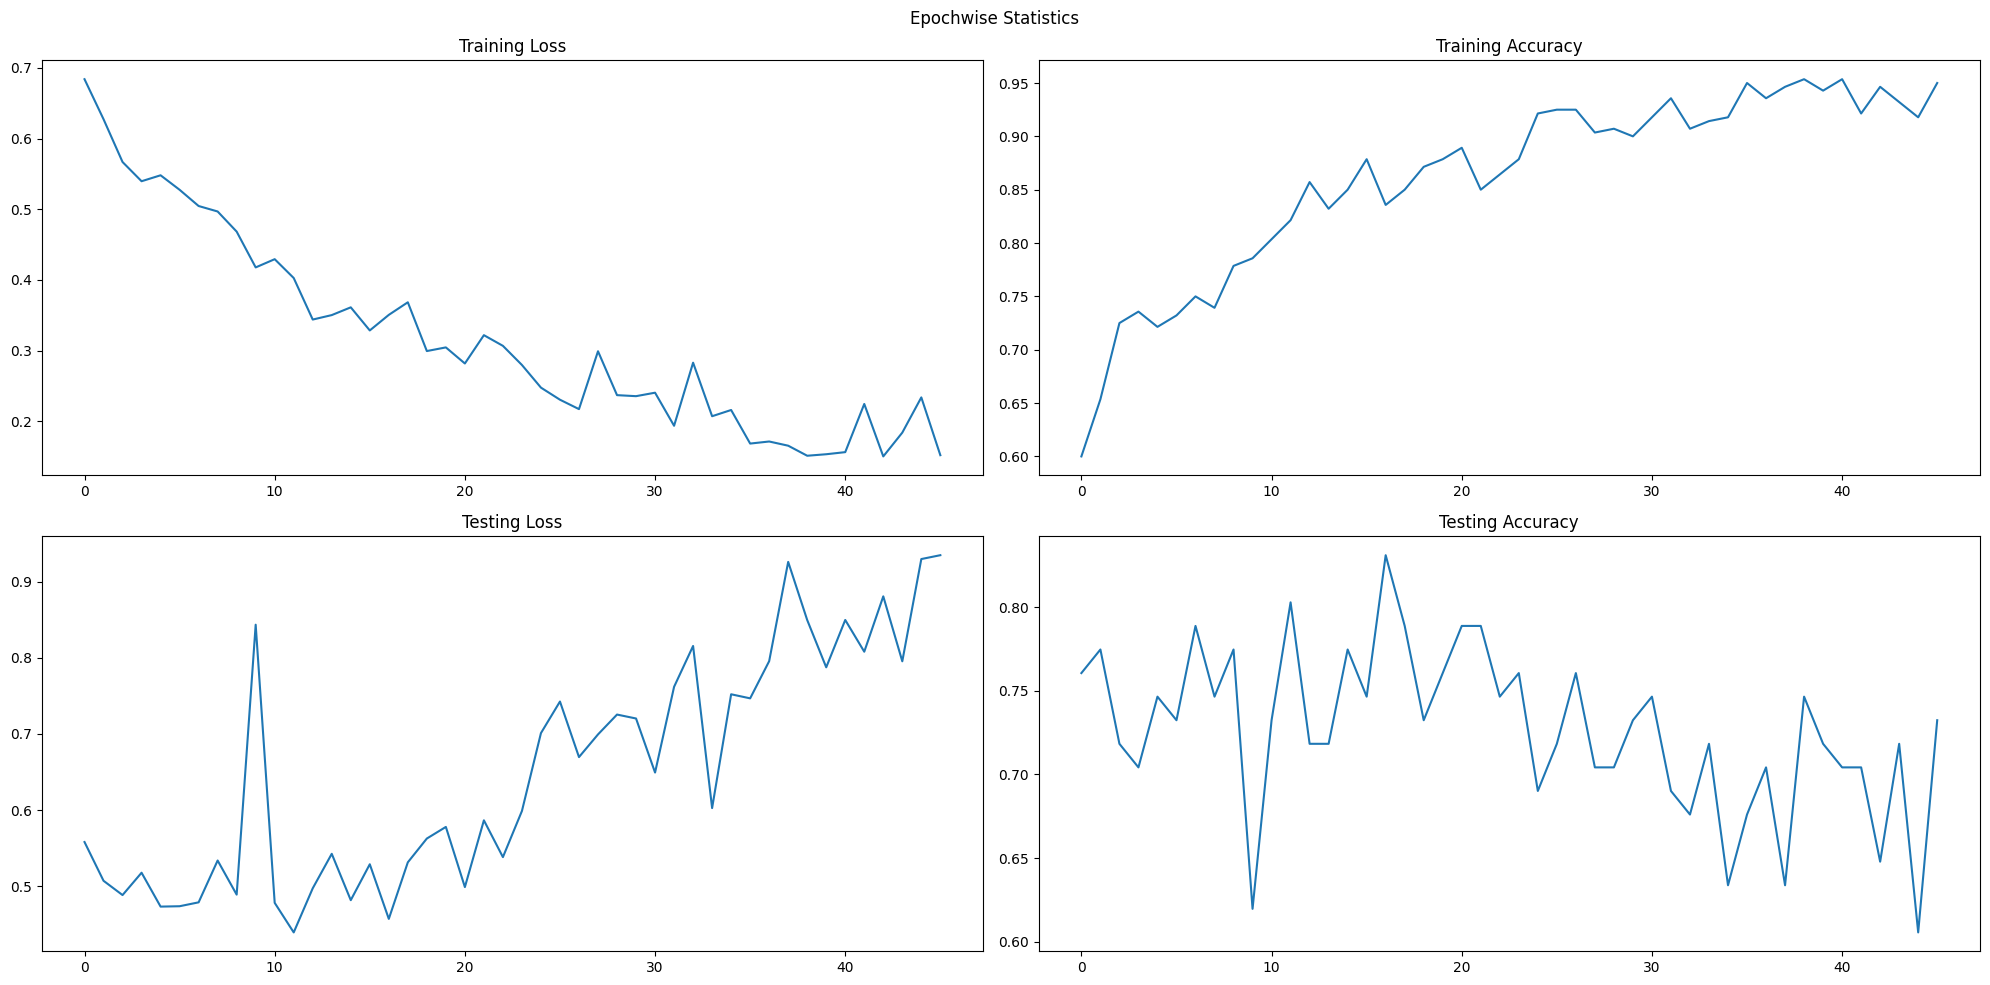

In [114]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(epochwisestats["train-loss.csv"])
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(epochwisestats["test-loss.csv"])
axs[1, 0].set_title("Testing Loss")

axs[0, 1].plot(epochwisestats["train-acc.csv"])
axs[0, 1].set_title("Training Accuracy")

axs[1, 1].plot(epochwisestats["test-acc.csv"])
axs[1, 1].set_title("Testing Accuracy")

fig.suptitle(f"Epochwise Statistics")
plt.show()

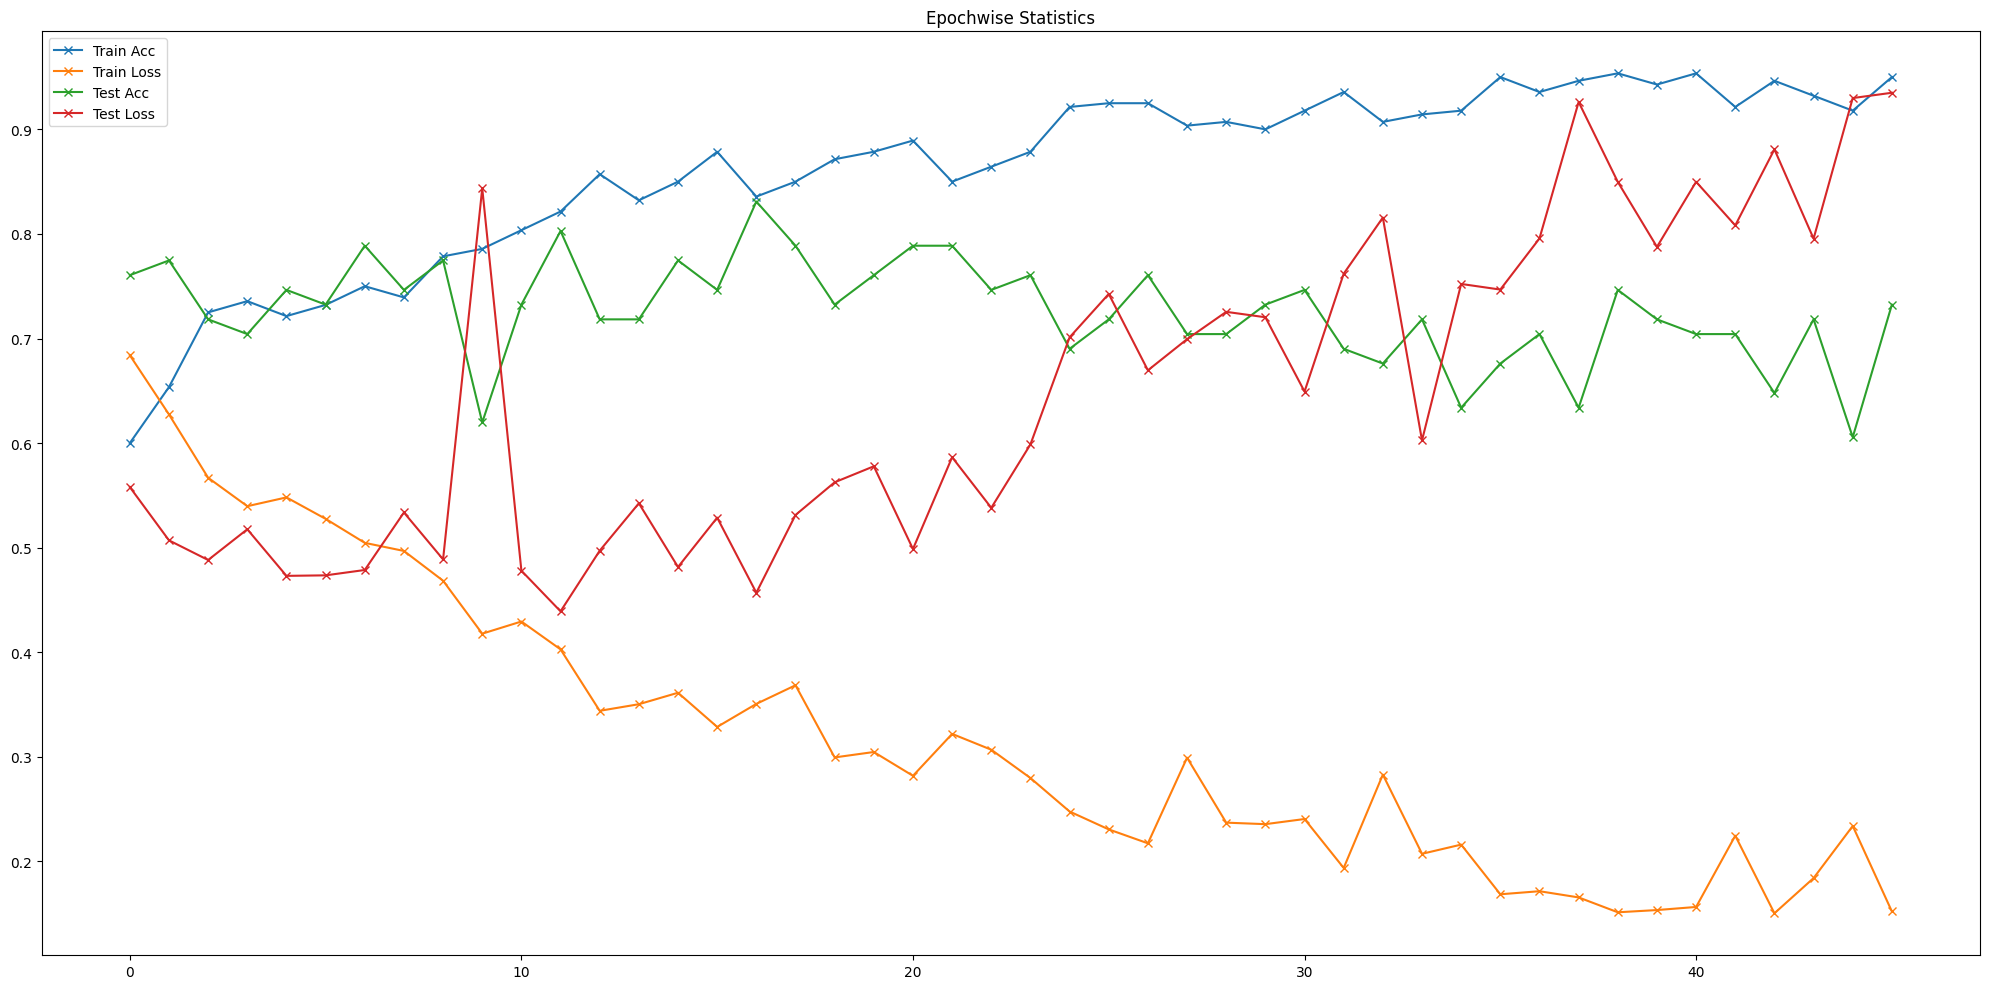

In [115]:
for key, val in epochwisestats.items():
    plt.plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
plt.title("Epochwise Statistics")
plt.legend()
plt.show()

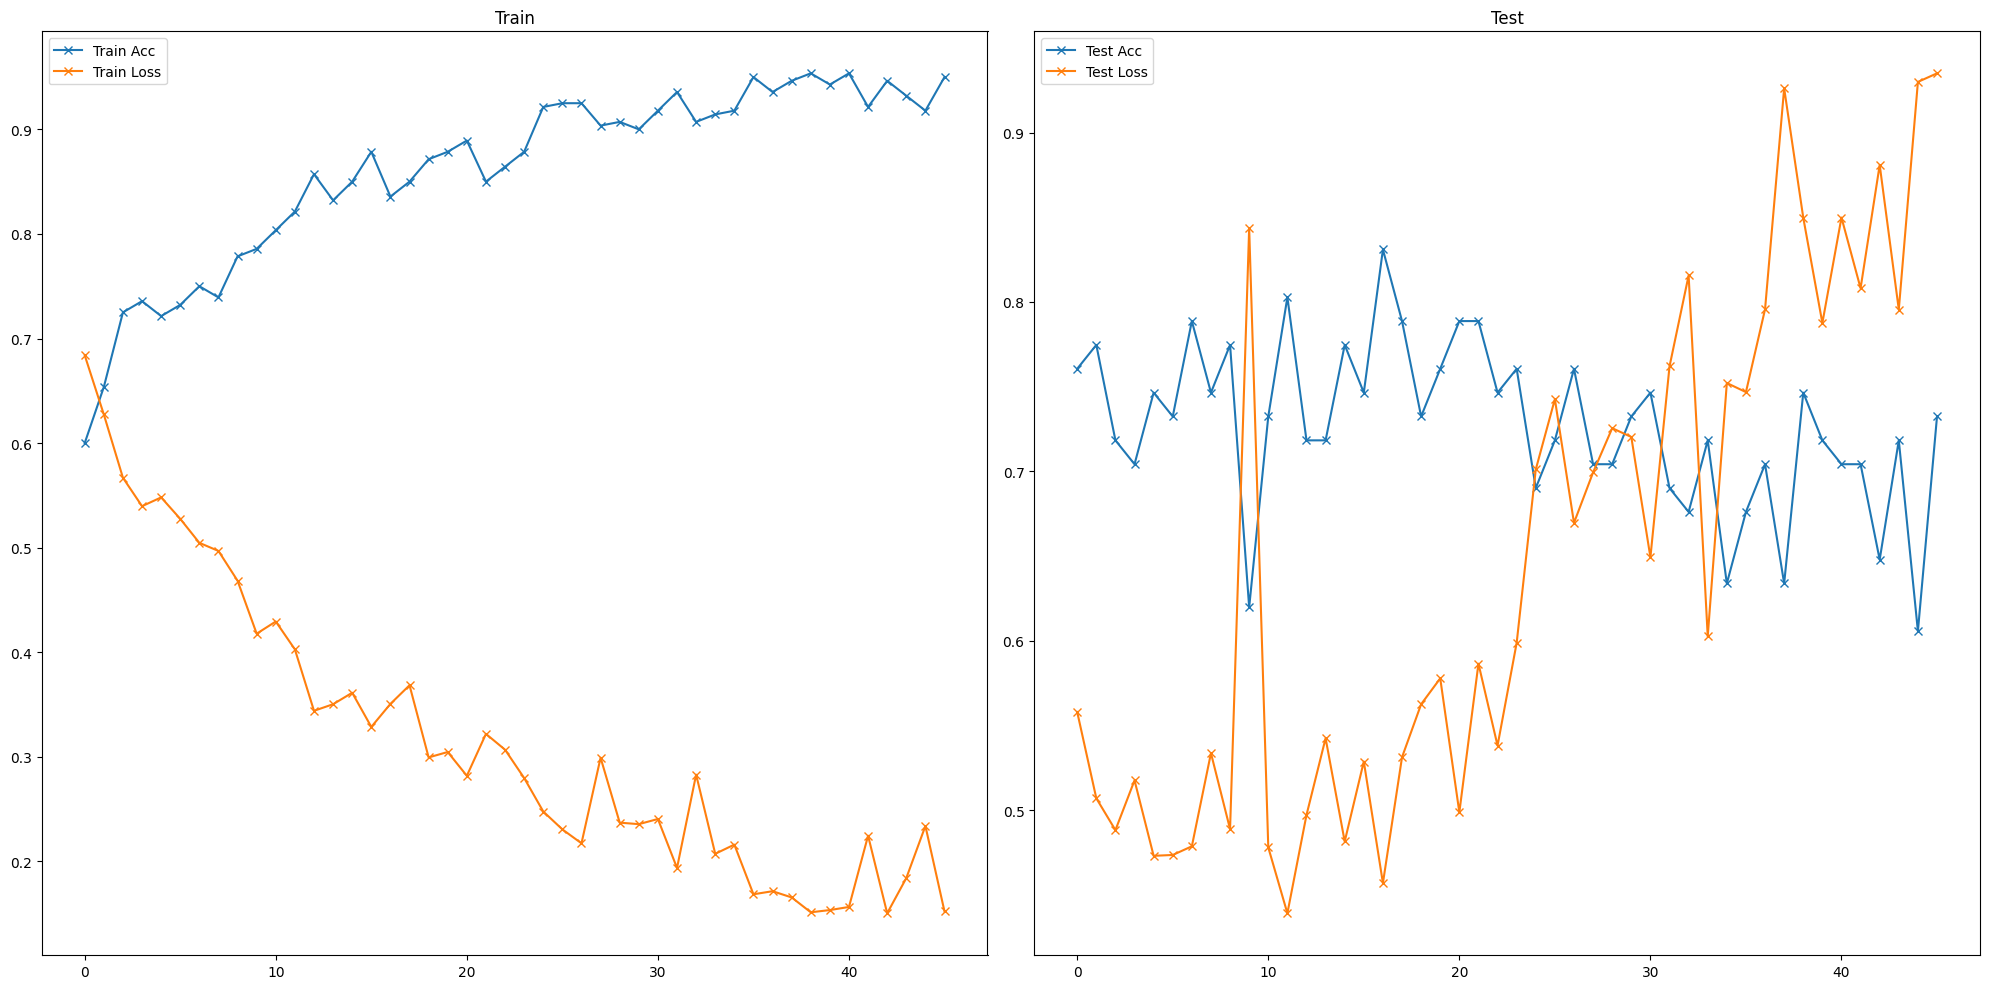

In [116]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "train" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
axs[0].legend()
axs[0].set_title("Train")
axs[1].legend()
axs[1].set_title("Test")
plt.show()

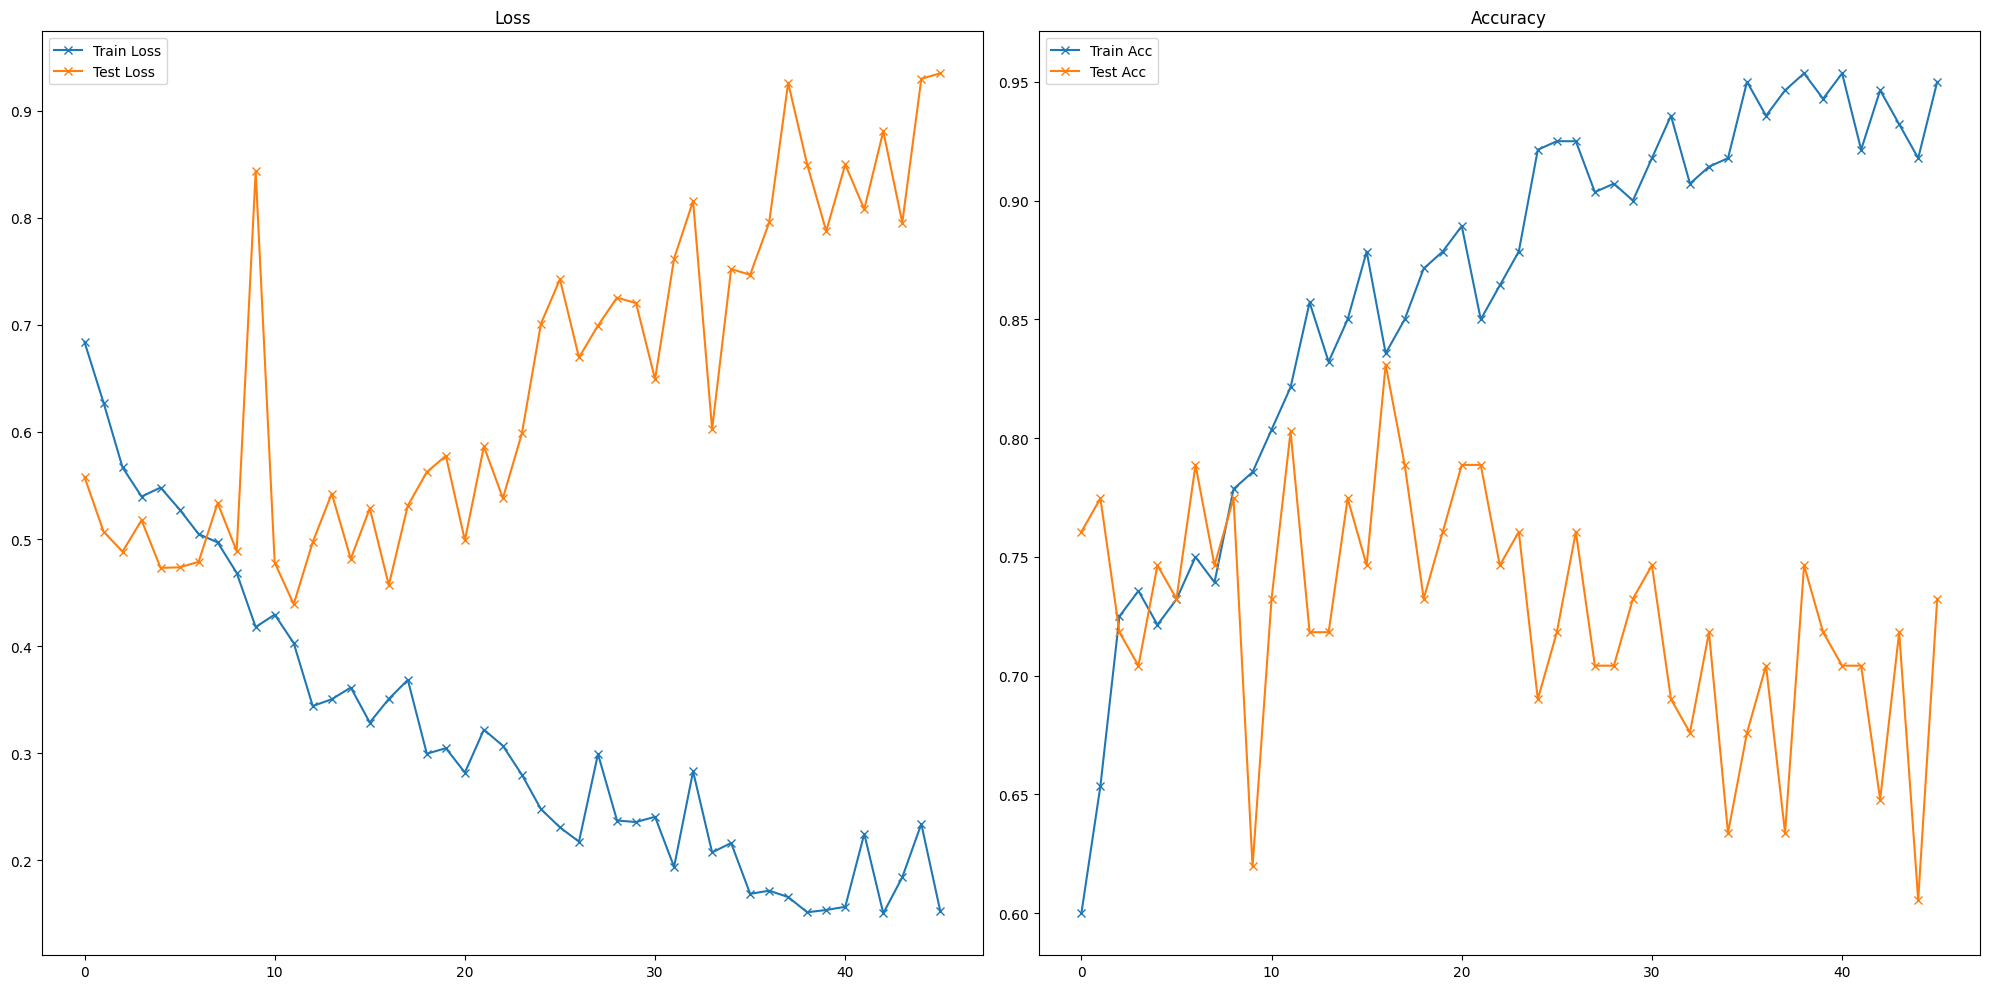

In [117]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "loss" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
plt.show()

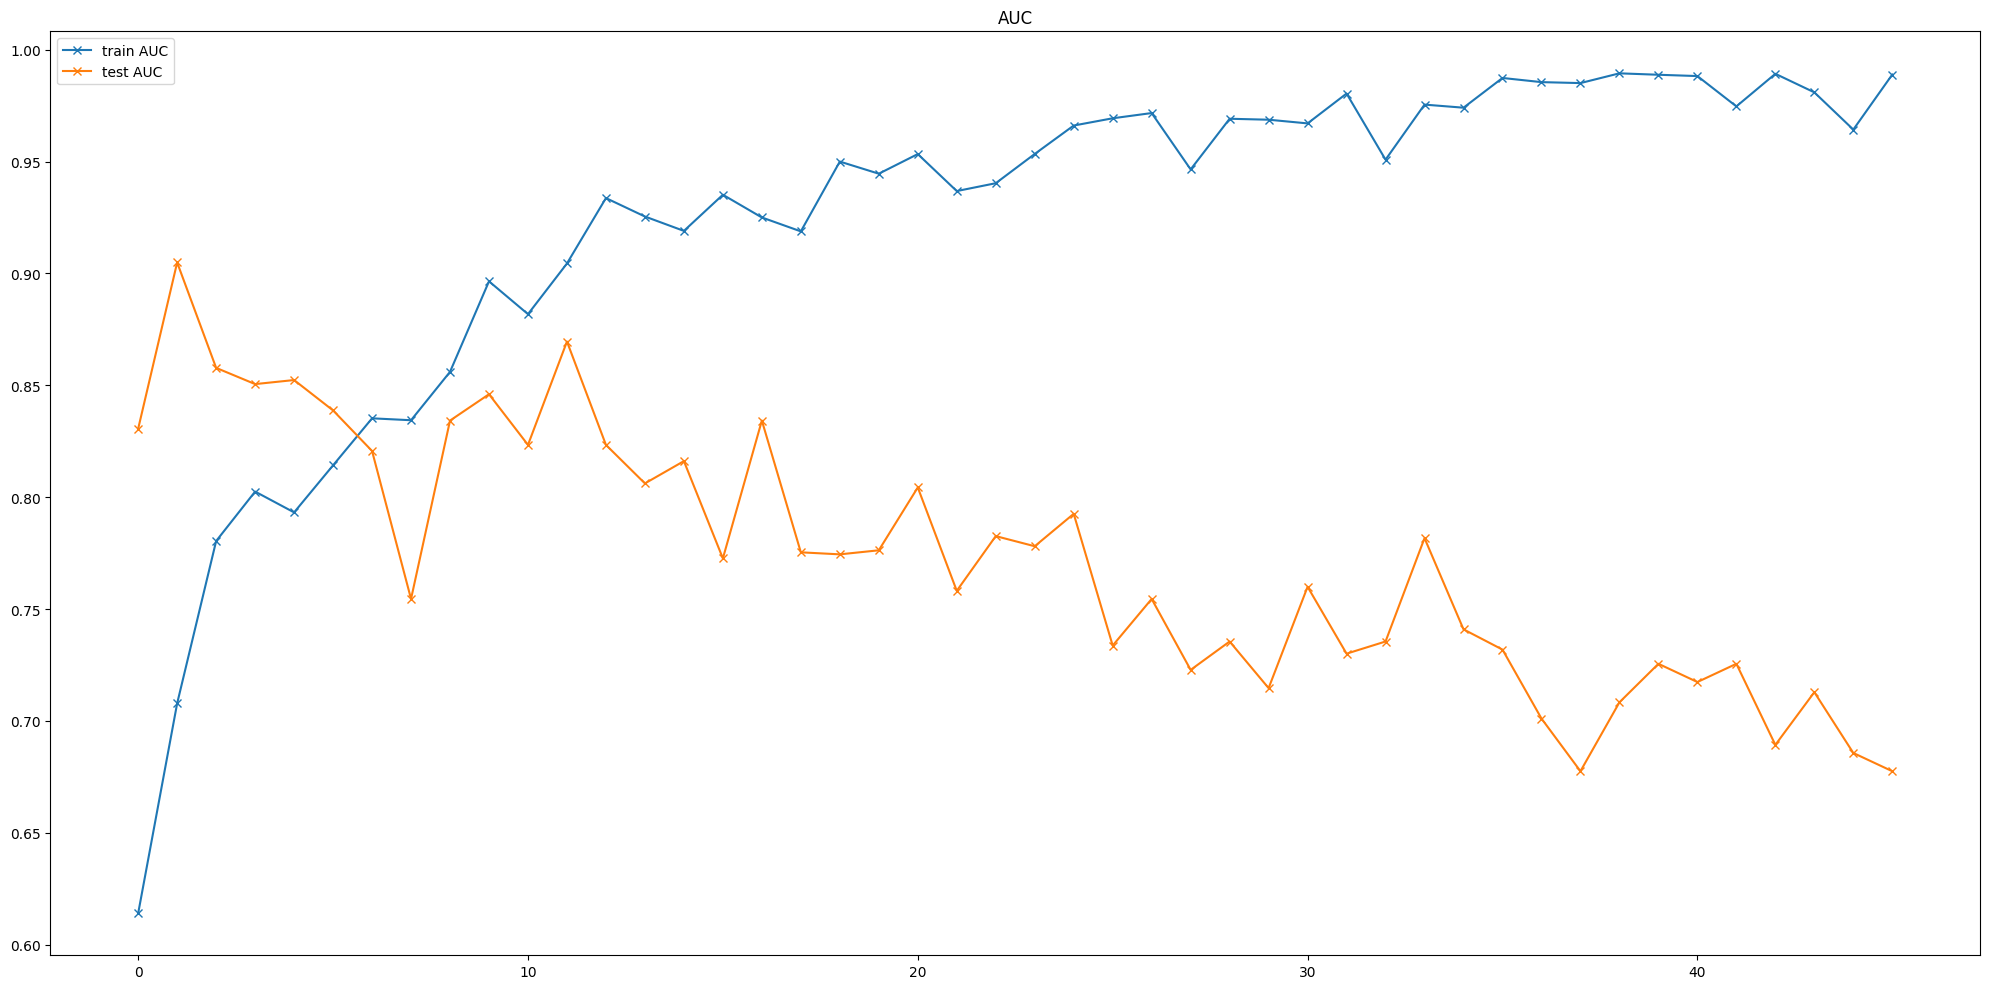

In [118]:
for key, val in aucstats.items():
    t = key.replace(".csv", "").split("-")[0]
    plt.plot(val, label = f"{t} AUC", marker = "x")

plt.title("AUC")
plt.legend()
plt.show()

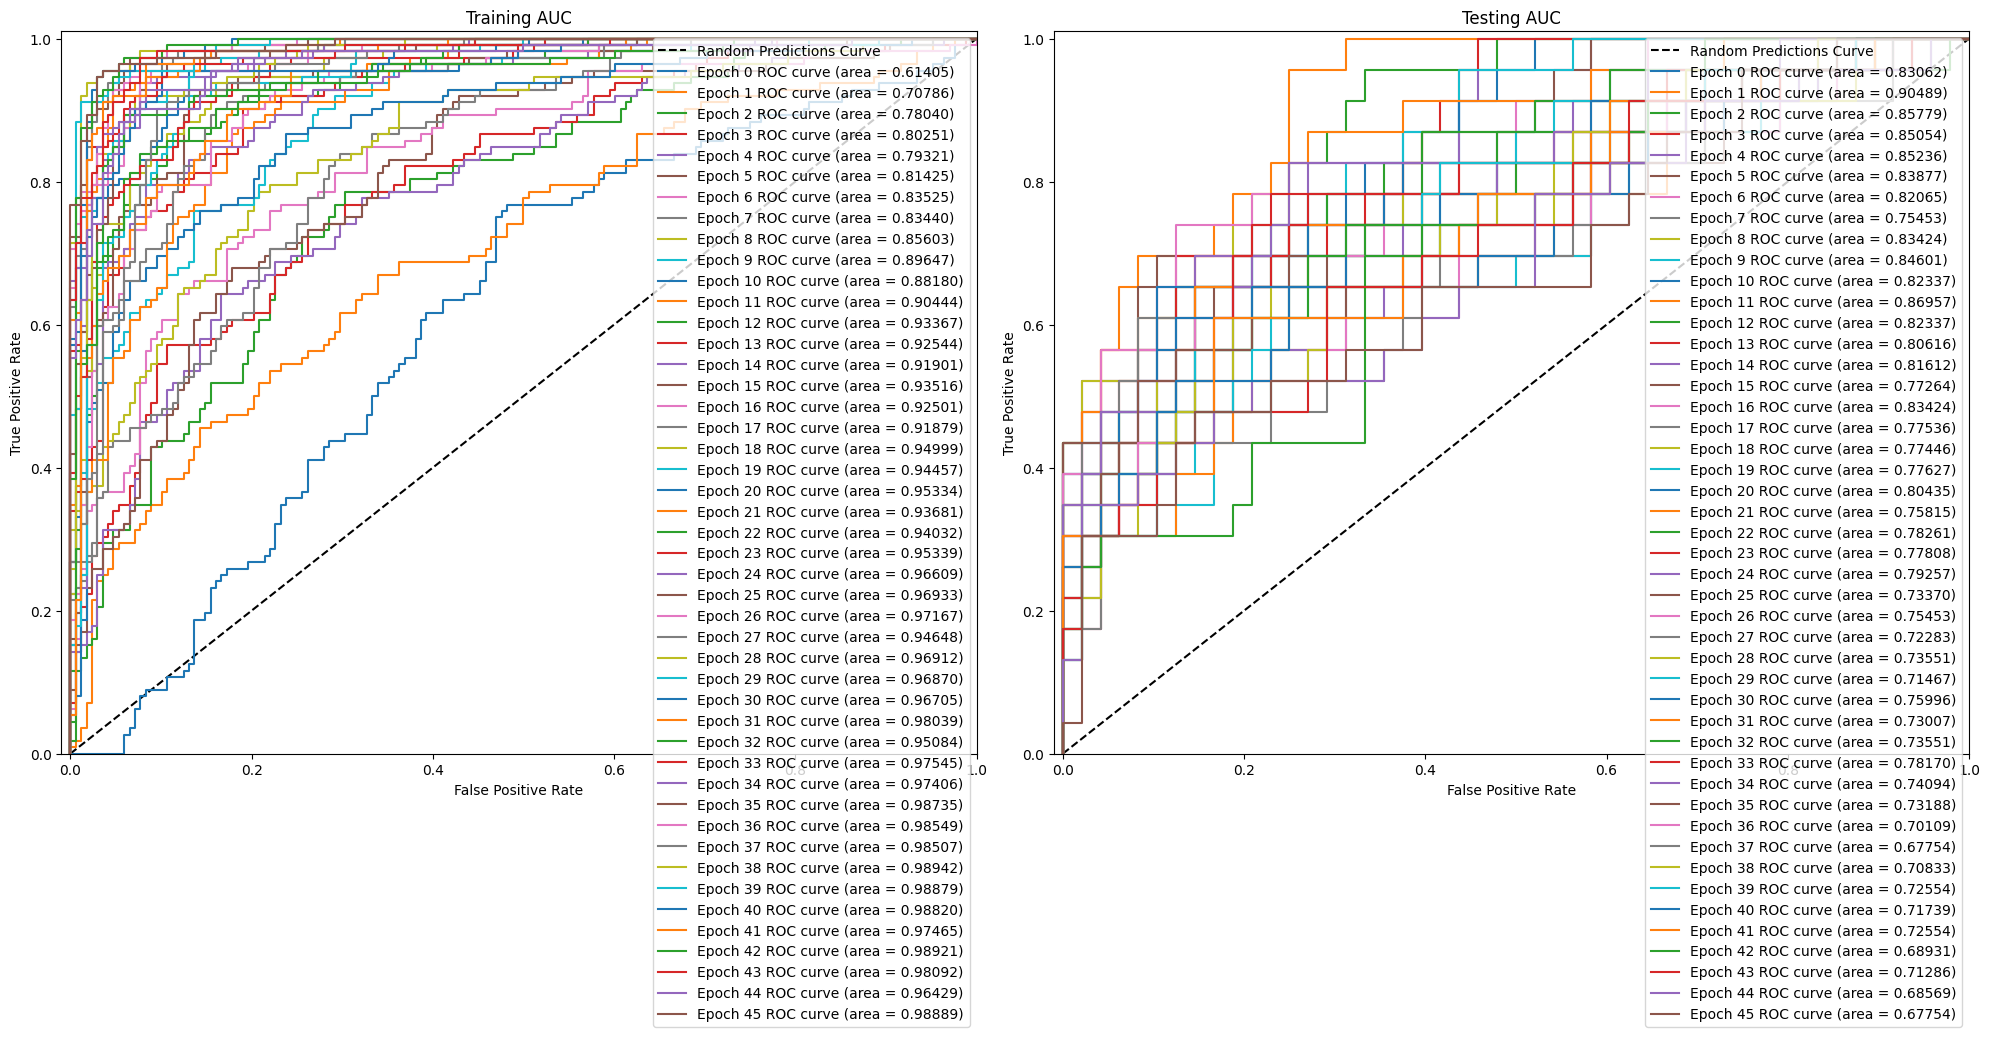

In [119]:
fig, axs = plt.subplots(ncols = 2)

axs[0].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")
axs[1].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")

try:
    for epoch in range(len(list(aucstats.values())[0])):
        for key in epochwiseauc.keys():
            fpr, tpr, thresholds = epochwiseauc[key][epoch]
            axs[0 if "train" in key else 1].plot(fpr, tpr, label = f"Epoch {epoch} ROC curve (area = {aucstats[key][epoch]:.5f})")
            axs[0 if "train" in key else 1].set_xlim([-0.01, 1])
            axs[0 if "train" in key else 1].set_ylim([0, 1.01])
            axs[0 if "train" in key else 1].set_xlabel("False Positive Rate")
            axs[0 if "train" in key else 1].set_ylabel("True Positive Rate")
except KeyError:
    pass

axs[0].legend()
axs[1].legend()
axs[0].set_title("Training AUC")
axs[1].set_title("Testing AUC")
plt.show()

In [120]:
import numpy as np
bestepoch = np.argmax(aucstats['test-preds.csv'])
bestepoch

1